# CS 363M | Final Project, Fall 2023

By **Lochana Kalyanaraman**, **Mahta Ghotbiravandi**, **Nicholas Ensey**, and **Rasheek Huq**

>#### **WARNING:**
> Do not run this entire file at once without checking the warning at the top of the **Modeling** section. If you want to rerun something, rerun everything in the **Data Preparation** section **before** *Exploration*, then you can rerun anything else (after checking the other warning).\
>The models do not depend on each other, only on the initial data prep, so you don't have to worry about running the entire file to be able to run a specific model's code.

>#### **Note:**
>I recommend using VSCode to view this file so that you can see the file's organization better. With VSCode, you can collapse different sections and subsections so that you can navigate through the file's sections more conveniently.

##### *Imports*

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.model_selection as ms
from sklearn import tree
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

***
# **Introduction**
***

This project is about engineering and refining a machine learning model that can help health care facilities better evaluate the risk of death in patients with COVID/flu-like symptoms.

It is often difficult to predict whether a patient is at high risk of death when many patients with similar symptoms can have drastically different outcomes. With a model that can accurately predict this, health care professionals will have another metric to decide how to treat different patients, allowing health care facilities to save more lives and potentially save resources for lower risk patients. This model is not intended to be a singular solution to determine a patient's care, but rather a quick and efficient aid to help make a better decision, faster.

The dataset we found was provided by the Mexican government, and contains over 1 million records of different people that were presented with flu-like symptoms. The dataset includes age, recorded symptoms, the level of care they received, their date of death (if they died), and several related pre-conditions that could potentially help predict the patient's future. There is a total of 21 features.

***
# **Data Preparation**
***

[Link to the dataset's page](https://www.kaggle.com/datasets/meirnizri/covid19-dataset/data)

## Initial Cleaning

In [2]:
data_raw = pd.read_csv('Covid Data.csv', header='infer')
print("Shape of original data:", data_raw.shape)
data_raw.head(3)

Shape of original data: (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2


In order to fix typos, improve readability, and make the dataset easier to work with, we decided to rename all of the features.

In [3]:
names = {'MEDICAL_UNIT':'Med_Unit', 'SEX':'Sex', 'PATIENT_TYPE':'Hospitalized', 'DATE_DIED':'Died', 
         'INTUBED':'Intubed', 'PNEUMONIA':'Pneumonia', 'AGE':'Age', 'PREGNANT':'Pregnant', 
         'DIABETES':'Diabetes', 'ASTHMA':'Asthma', 'INMSUPR':'Imnsupr', 'HIPERTENSION':'Hypertension', 
         'OTHER_DISEASE':'Other_Disease', 'CARDIOVASCULAR':'Cardiovascular', 'OBESITY':'Obesity', 
         'RENAL_CHRONIC':'Renal_Chronic', 'TOBACCO':'Tobacco', 'CLASIFFICATION_FINAL':'COVID'}
data_raw.rename(columns=names, inplace=True)
data_raw.head(3)

,USMER,Med_Unit,Sex,Hospitalized,Died,Intubed,Pneumonia,Age,Pregnant,Diabetes,...,Asthma,Imnsupr,Hypertension,Other_Disease,Cardiovascular,Obesity,Renal_Chronic,Tobacco,COVID,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2


#### From here, we decided to change the way many of the values were presented in the original dataset.
> *(all changes are indented like this)*
- For boolean variables, the original marks them as '1' for True and '2' for False.
> We changed all of the '2's to '0's, to make them more like regular booleans.
- For 'Hospitalized', a True value indicated that the patient returned home, and False indicated that they were hospitalized.
> Since we named the feature 'Hospitalized', we swapped the True/False values ('1's and '0's) to better fit the feature name.
- Missing values for all features besides 'Age' and 'Died' were marked as 98 or 99.
> We changed them to None, so pandas would detect them as missing.
- For 'Pregnant', a value of '97' indicated that it was a male, who can't get pregnant anyways.
> We changed these to simply be '0', or False, because the '97's did not give us any new information, and allowed for the 'Pregnant' feature to remain strictly binary.
- For 'ICU' and 'Intubed', a 97 was tied to the 'Hospitalized' feature being False, and indicated that since the patient was not hospitalized, they did not have a chance to be intubed.
> We changed these values to '0', as it was redundant data and allowed for 'ICU' and 'Intubed' to be binary.
- For 'Died', the data originally has their date of death, and '9999-99-99' if they did not die.
> Since there is no other indication of what time frame they were admitted/treated in, there was no use to knowing when they died. So we decided to simply make this into a boolean indicating whether or not they died at all.
- Finally, the 'COVID' feature for each record had a few possible values. If it was between 4-7, then they did not have COVID or the test was inconclusive. If it was between 1-3, then they did have COVID, with each number being a different severity. There is no indication of what number indicated what severity.
> We changed all of the False/inconclusive values (4-7) to '0', since there is no indication as to which is which, and essentially gives us the same amount of information.

In [4]:
data = data_raw.copy(deep=True)
for col in data.columns:
    if col not in ['Age', 'COVID', 'Died']:
        data[col].replace(to_replace=[97, 2, 98, 99], value=[0, 0, None, None], inplace=True)
data['Died'].replace(to_replace=['9999-99-99', '[123456780]*'], value=[0, 1], regex=True, inplace=True)
data['COVID'].replace(to_replace=[4,5,6,7], value=[0,0,0,0], inplace=True)
data = data.fillna(pd.NA).astype('Int32') # prevents boolean features with missing values becoming floats

Looking at the different severity values for 'COVID' positive records, there isn't much of a difference in the data that would be statistically relevant.

In [5]:
print(data.groupby('COVID')['Died'].value_counts())

COVID  Died
0      0       633890
       1        22706
1      0         7646
       1          955
2      1         1851
3      0       330097
       1        51430
Name: Died, dtype: int64


Only a very small portion of COVID positive people were marked as 1 or 2. Furthermore, the correlation with whether they died or not was barely effected when we changed all of the positive values to '1'

In [6]:
print("COVID correlation with Died:", data.corr()['Died']['COVID'])
data['COVID'].replace(to_replace=[1,2,3], value=[1,1,1], inplace=True)
print("Boolean COVID correlation with Died:", data.corr()['Died']['COVID'])

COVID correlation with Died: 0.18813498215432248
Boolean COVID correlation with Died: 0.1925637699393495


Thus,
> 'COVID' was turned into a binary feature, only indicating whether the person tested positive or not.

Other people working with this dataset (in the Discussion tab of the dataset page) also made the same change without much adverse effect, so we decided to stick with this.

## Missing Values

To deal with missing values, we decided to look at how many records there were with such values.

In [7]:
print("Num records:", data.shape[0])
data2 = data.dropna()
print("Num records dropped:", (data.shape[0]-data2.shape[0]))

Num records: 1048575
Num records dropped: 28909


In [8]:
print(data.groupby('Died').size())
print("Alive records dropped:", (data.groupby('Died').size()[0]-data2.groupby('Died').size()[0]))
print("Dead records dropped:", (data.groupby('Died').size()[1]-data2.groupby('Died').size()[1]))

Died
0    971633
1     76942
dtype: int64
Alive records dropped: 25277
Dead records dropped: 3632


Seeing that the total amount of such records was low, and did not exacerbate the class imbalance very much, we decided to just drop all records with missing values.

In [9]:
data = data2

## Class Imbalance

Speaking of the class imbalance, we noticed there was a very large imbalance in our dataset, with the positive case being the minority. About 7% of records in the dataset were positive.

In [10]:
print((data.groupby('Died').size()[1]/data.shape[0]))

0.0718960914652445


This resulted in all of our initial models having a very low positive precision, recall, and accuracy. To mitigate this, we found a parameter in many of scikit-learn's classes called 'class_weight', which allowed us to weigh the impact of the positive class much more than the negative class. As you'll see in the models below, this greatly benefitted the overall performance of our models.

However, some model types did not have this parameter built in, and generally had worse performance because of it. So we tried undersampling the dataset's negative records to consolidate their information, but we generally could not get it to work properly or run in a reasonable amount of time, so we ended up not being able to use it (this was discussed in office hours).

The algorithm we attempted to use came from the imblearn package (requires installing via conda or pip), called [Cluster Centroids](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.ClusterCentroids.html). It essentially runs a KMeans clustering algorithm on the dataset's majority class and replaces the records in each cluster with their corresponding centroid. This would greatly reduce the total amount of negative records while retaining a lot of their information.

Since we couldn't get this to work, the models that did not have the 'class_weight' parameter available generally performed worse.

## More Feature Selection

In [11]:
features = data.drop('Died', axis=1)
labels = data['Died'].values.ravel()
f1 = features

- We decided to drop the ICU feature due to a high correlation with the Hospitalized and Intubed features. Also, logical assumption that if they are in the ICU, we can assume they were hospitalized in the first place. Overall, removed to reduce redundancy. (f2)

In [12]:
data.corr()['ICU']

USMER             0.034885
Med_Unit          0.016633
Sex              -0.034399
Hospitalized     -0.267860
Died              0.204008
Intubed           0.374589
Pneumonia         0.259865
Age               0.074548
Pregnant          0.003307
Diabetes          0.073355
COPD              0.025905
Asthma           -0.005095
Imnsupr           0.028438
Hypertension      0.062371
Other_Disease     0.025322
Cardiovascular    0.036282
Obesity           0.033964
Renal_Chronic     0.030348
Tobacco           0.001451
COVID             0.064147
ICU               1.000000
Name: ICU, dtype: float64

- When evaluating the data and reading the dataset page, there was no indication of what each value meant, so we decided to drop Med_Unit as a feature to make the dataset more concise. (f3)

The next set of features were dropped due to low correlation with death.

In [13]:
data.corr()['Died']

USMER             0.117652
Med_Unit         -0.154907
Sex              -0.079927
Hospitalized     -0.517813
Died              1.000000
Intubed           0.504964
Pneumonia         0.471531
Age               0.320703
Pregnant         -0.021001
Diabetes          0.215750
COPD              0.089570
Asthma           -0.017690
Imnsupr           0.049774
Hypertension      0.203158
Other_Disease     0.057231
Cardiovascular    0.076183
Obesity           0.055409
Renal_Chronic     0.119538
Tobacco           0.005625
COVID             0.190817
ICU               0.204008
Name: Died, dtype: float64

- Dropped the Sex, Pregnant, Asthma, and Tobacco due to a less than a 2% correlation (f4)
- Dropped Obesity, Cardiovascular, Other_Disease, Imnsupr, COPD due to a less than 10% correlation (f5)
- Dropped Renal_Chronic and USMER due to it having the smallest correlation out of the remaining features (f6)

In [14]:
f2 = features.drop('ICU', axis=1)
f3 = f2.drop('Med_Unit', axis=1)
f4 = f3.drop(['Sex', 'Pregnant', 'Asthma', 'Tobacco'], axis=1) # <2% correlation
f5 = f4.drop(['Obesity', 'Cardiovascular', 'Other_Disease', 'Imnsupr', 'COPD'], axis=1) # <10% correlation
f6 = f5.drop(['Renal_Chronic', 'USMER'], axis=1) # lowest correlation

These are the different feature sets we used throughout our models, but not every model had their best results with the same set. 

Below are some additional feature combinations tested in some models.

In [15]:
f7 = features.drop('Med_Unit', axis=1)
f8 = features.drop('Hospitalized', axis=1)
f9 = f7.drop('Hospitalized', axis=1)

## Exploration

Based on the following histogram, the group that experienced the highest death rate relative to the rest of the distribution is those in the 50-70 age bracket. This is not to say those older than 70 were less likely to pass away. In proportion with the age distribution, there are simply fewer records in the 80+ age bracket.

Text(0.5, 1.0, 'Death by Age Distribution')

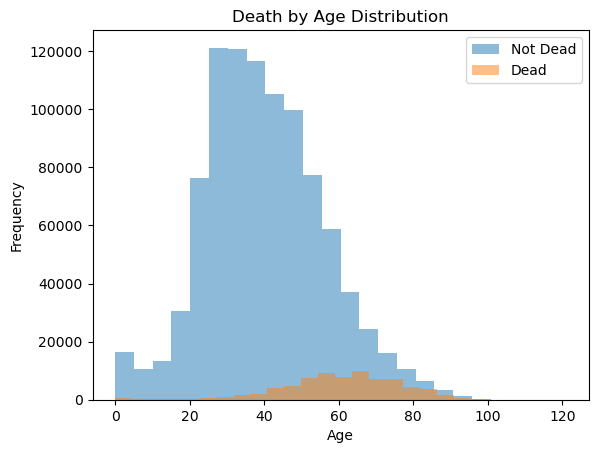

In [26]:
data.groupby('Died')['Age'].plot.hist(bins=24, alpha=0.5)
plt.legend(labels=["Not Dead", "Dead"])
plt.xlabel('Age')
plt.title("Death by Age Distribution")

The following graph shows covid and death rate over age. We can see that the mean age for those who died without Covid is 60. The max is 110. The mean age for Covid and died is 65. The max is 105.

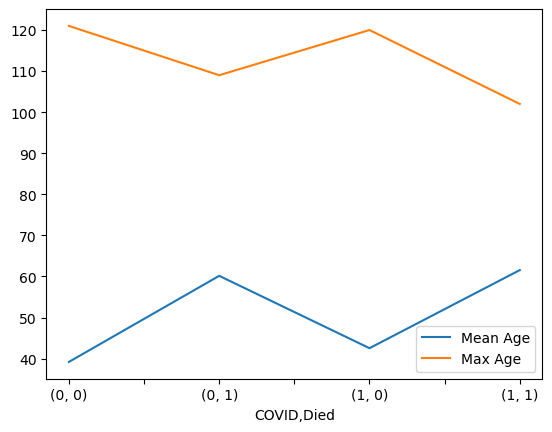

In [24]:
data.groupby(['COVID', 'Died']).agg({'Age': ['mean', 'max']}).plot()
plt.legend(['Mean Age', 'Max Age'])

Looking further into the age gap, we didn't end up learning much that affected our modeling, but there were some interesting findings.

In [40]:
data.groupby('Died')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Died,,,,,,,,
0,946356.0,40.376969,15.895617,0.0,29.0,39.0,50.0,121.0
1,73310.0,61.153076,15.257528,0.0,52.0,62.0,72.0,109.0


In [41]:
data['Age'].describe()

count    1019666.0
mean      41.87069
std      16.734508
min            0.0
25%           30.0
50%           40.0
75%           53.0
max          121.0
Name: Age, dtype: Float64

Here, we decided to separate each quarter of the dataset by age.

In [42]:
top = data[data['Age'] >= 40]
bottom = data[data['Age'] < 40]
firstq = bottom[bottom['Age'] < 30]
secondq = bottom[bottom['Age'] >= 30]
thirdq = top[top['Age'] < 53]
fourthq = top[top['Age'] >= 53]

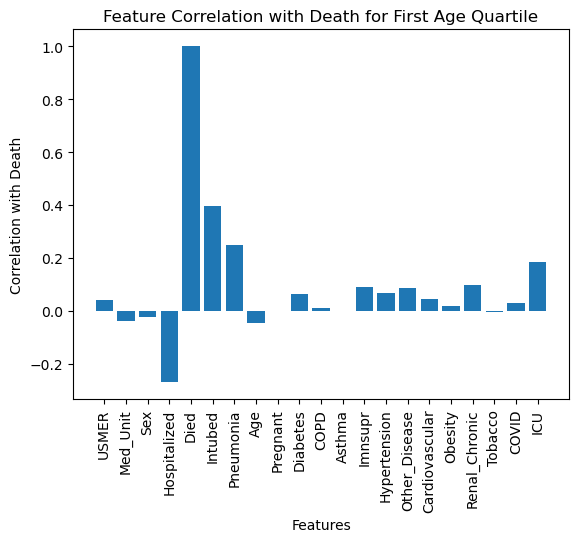

In [68]:
plt.bar(x=list(range(1,22)), height=(firstq.corr()['Died']))
ticks = plt.xticks(ticks=list(range(1,22)), labels=data.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Death')
title = plt.title('Feature Correlation with Death for First Age Quartile')

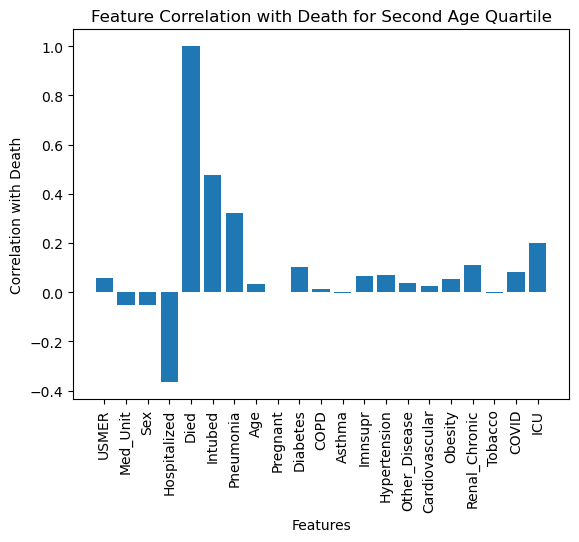

In [69]:
plt.bar(x=list(range(1,22)), height=(secondq.corr()['Died']))
ticks = plt.xticks(ticks=list(range(1,22)), labels=data.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Death')
title = plt.title('Feature Correlation with Death for Second Age Quartile')

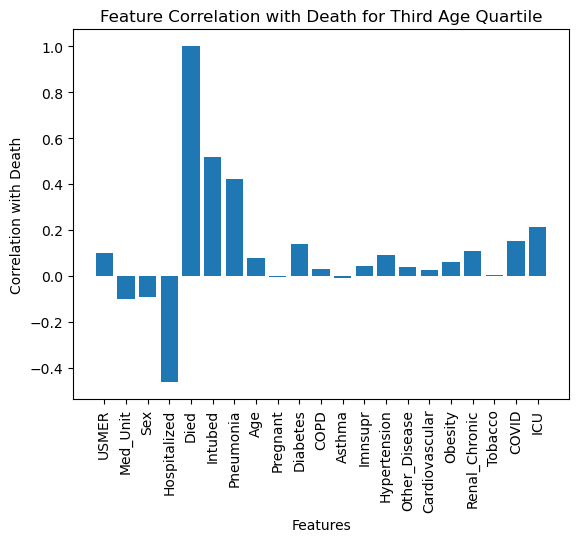

In [70]:
plt.bar(x=list(range(1,22)), height=(thirdq.corr()['Died']))
ticks = plt.xticks(ticks=list(range(1,22)), labels=data.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Death')
title = plt.title('Feature Correlation with Death for Third Age Quartile')

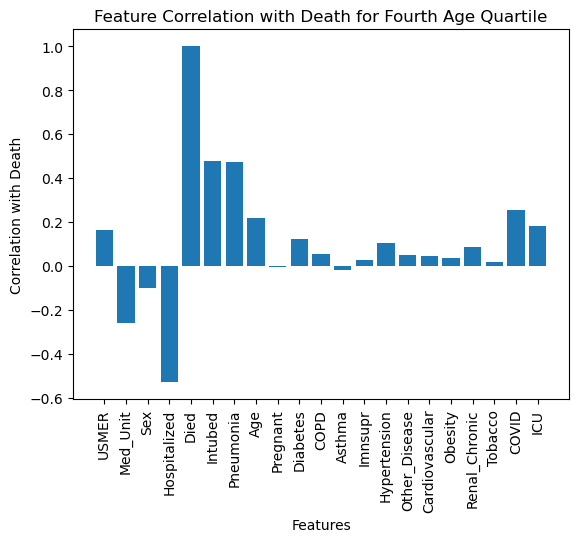

In [71]:
plt.bar(x=list(range(1,22)), height=(fourthq.corr()['Died']))
ticks = plt.xticks(ticks=list(range(1,22)), labels=data.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with Death')
title = plt.title('Feature Correlation with Death for Fourth Age Quartile')

In the last quarter, it looks like the correlation between death and 'Hospitalized' and 'COVID' significantly increased. Also, each quartile's correlation between 'Age' and death increased, indicating that the increased risk of death that comes from age is not linear, but quadratic/exponential.

Based on the plot below, the distribution is approximately the same amongst male and female records. It is evident that male records were more likely to die in comparison their female counterparts, though by a relatively small margin. 

([<matplotlib.axis.XTick at 0x26221faa8d0>,
 [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

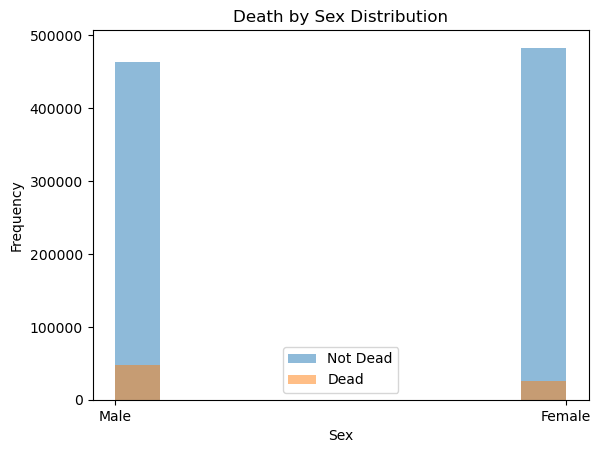

In [21]:
data.groupby('Died')['Sex'].plot.hist(alpha=0.5)
plt.legend(labels=["Not Dead", "Dead"])
plt.xlabel('Sex')
plt.title("Death by Sex Distribution")
plt.xticks([0, 1], ['Male', 'Female'])

This plot how the number of people with pneumonia and whether they died. The patients were more likely to not have pneumonia and not die.

([<matplotlib.axis.XTick at 0x26223507250>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

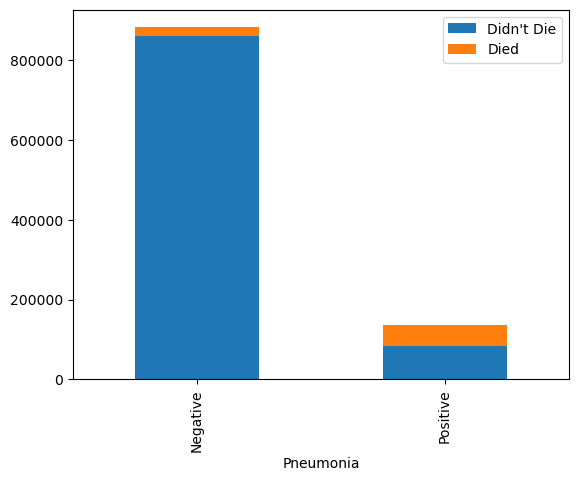

In [26]:
pd.crosstab(data['Pneumonia'],data['Died']).plot(kind="bar",stacked=True)
plt.legend(["Didn't Die", "Died"])
plt.xticks([0, 1], ['Negative', 'Positive'])

This plot how the number of people who were intubed and whether they died. The patients were more likely to not be intubed and not die.

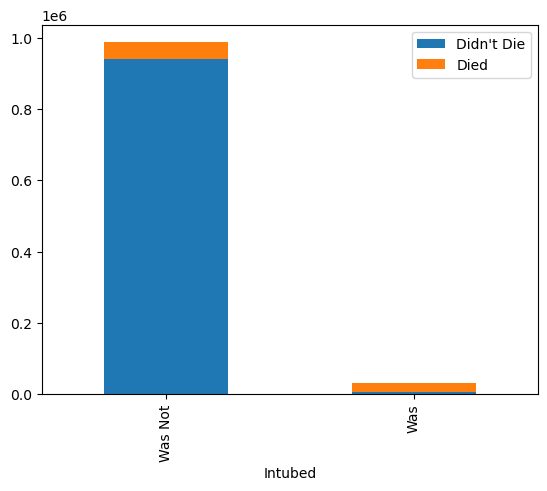

In [39]:
pd.crosstab(data['Intubed'],data['Died']).plot(kind="bar",stacked=True)
plt.xticks([0, 1], ['Was Not', 'Was'])
plt.legend(["Didn't Die", "Died"])

## Anomaly Detection

We aimed to see outliers in the data. To do this, we used a contamination of 0.01 and 0.05. There were no improvements when we removed outliers. Therefore, we preliminarily did not use this dataset further.

>Note: The following code is based on a model that we developed later in this notebook, and was used to test the effectiveness of our anomaly detection. The model itself is explored in the **Modeling** section.

In [50]:
data_outliers = data.to_numpy()

x = EllipticEnvelope(contamination = 0.01).fit(data_outliers)
y_pred = pd.DataFrame(x.predict(data_outliers))
print(y_pred.value_counts())
preds = pd.DataFrame(y_pred).replace(to_replace=[-1,1], value=[False, True]).values.ravel()
d = data.loc[preds,:]
print(d.shape)
print(d.groupby('Died').size())

 1    1009470
-1      10196
dtype: int64
(1009470, 21)
Died
0    939520
1     69950
dtype: int64


In [51]:
features_outliers = d.drop('Died', axis=1)
labels_outliers = d['Died'].values.ravel()
out = features_outliers.drop(['ICU', 'Med_Unit', 'Sex', 'Pregnant', 'Asthma', 'Tobacco', 'Obesity', 'Cardiovascular', 'Other_Disease', 'Imnsupr', 'COPD', 'Renal_Chronic'], axis=1)
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, out, labels_outliers, cv=15, error_score ='raise')
print("Accuracy:", scores.mean()*100)
preds = ms.cross_val_predict(gnb, out, labels_outliers, cv=10)
print(metrics.confusion_matrix(labels_outliers, preds))
print(metrics.classification_report(labels_outliers, preds))

Accuracy: 91.50078754197747
[[865992  73528]
 [ 12751  57199]]
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95    939520
         1.0       0.44      0.82      0.57     69950

    accuracy                           0.91   1009470
   macro avg       0.71      0.87      0.76   1009470
weighted avg       0.95      0.91      0.93   1009470



The following code runs Elliptic Envelope with 0.05 as contamination. After dropping the outliers it detected, the accuracy of the same model improved but recall and precision for positive class decreased. Hence, it is not optimal. (slightly varied results with different seeds, but generally no better results)

In [54]:
data_outliers = data.to_numpy()

x = EllipticEnvelope(contamination = 0.05).fit(data_outliers)
y_pred = pd.DataFrame(x.predict(data_outliers))
print(y_pred.value_counts())
preds = pd.DataFrame(y_pred).replace(to_replace=[-1,1], value=[False, True]).values.ravel()
d = data.loc[preds,:]
print(d.shape)
print(d.groupby('Died').size())

 1    968682
-1     50984
dtype: int64
(968682, 21)
Died
0    909681
1     59001
dtype: int64


In [55]:
features_outliers = d.drop('Died', axis=1)
labels_outliers = d['Died'].values.ravel()
out = features_outliers.drop(['ICU', 'Med_Unit', 'Sex', 'Pregnant', 'Asthma', 'Tobacco', 'Obesity', 'Cardiovascular', 'Other_Disease', 'Imnsupr', 'COPD', 'Renal_Chronic'], axis=1)
scores = ms.cross_val_score(gnb, out, labels_outliers, cv=15, error_score ='raise')
print("Accuracy:", scores.mean()*100)
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, out, labels_outliers, cv=10)
print(metrics.confusion_matrix(labels_outliers, preds))
print(metrics.classification_report(labels_outliers, preds))

Accuracy: 92.0038928008888
[[843059  66622]
 [ 11175  47826]]
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96    909681
         1.0       0.42      0.81      0.55     59001

    accuracy                           0.92    968682
   macro avg       0.70      0.87      0.75    968682
weighted avg       0.95      0.92      0.93    968682



We also attempted this outlier test with our final model near the end of this file, and obtained similar results, so we ultimately did not use any form of anomaly detection.

### Why didn't this help?

We decided to explore why this wasn't helping our model, and found some interesting results after a little bit of digging.

In [19]:
data_outliers = data.to_numpy()
x = EllipticEnvelope(contamination = 0.05).fit(data_outliers)
y_pred = pd.DataFrame(x.predict(data_outliers))
print("Totals (1: inlier, -1: outlier):")
print(y_pred.value_counts())
preds = pd.DataFrame(y_pred).replace(to_replace=[-1,1], value=[False, True]).values.ravel()
inliers = data.loc[preds,:]

Totals (1: inlier, -1: outlier):
 1    968687
-1     50979
dtype: int64


In [20]:
data_g = data.groupby('Died').size()
inliers_g = inliers.groupby('Died').size()
print("Negative records lost:")
print(data_g[0]-inliers_g[0])
print("Positive records lost:")
print(data_g[1]-inliers_g[1])

Negative records lost:
30743
Positive records lost:
20236


We lost positive/negative records at an approximately 2-3 ratio, while only 7% of all records in the dataset are positive. We believe that since the anomaly detection was exacerbating the class imbalance, it lead to even worse positive precision and recall, for the same reason the class imbalance was making the tuning of our models difficult in the first place.

***
# **Modeling**
***

>### **=========== WARNING: ===========**
> Some of the code cells in this section use the 'n_jobs' parameter, which determines the amount of cores and threads each class uses when they run. This was done to improve the runtimes of the models on my (Rasheek's) desktop, and the values I used are specific to my CPU. If you decide to rerun these cells, make sure to change this parameter or just get rid of it before doing so. More info [here](https://stackoverflow.com/questions/32761556/python-scikit-learn-n-jobs).

For our modeling process, we decided to thoroughly test several different models, tune them to their best, and choose the best one we could make.

Our initial thinking was that since this is a simple binary classification problem without highly complex decision boundaries (probably), a Decision Tree or a Naive Bayes Classifier would likely have good results. However, we still decided to try out many different kinds of models to see if there were any unexpected benefits.

### Modelling Goals

One problem that we frequently faced was that the precision and recall of the positive class (indicating death) was very poor. This was true for the early versions of many of our models of all types. As explained near the end of the Data Prep section, we reasoned that this was likely due to the large class imbalance reducing the model's available information about the positive class.

Increasing our model's positive precision and especially recall is very important, as the consequences of a false negative are very high, and our model's primary purpose is to detect when a patient is likely to die. This is why the main goal for our final model was to increase its sensitivity to positive cases, as in increase positive recall.

Although some of our tuning can accomplish this, it comes with the risk of increasing false positives, as in lowering positive precision. We decided that this would be generally acceptable within some margin, as the consequences of a false negative greatly outweigh the consequences of a false positive.

Accidentally releasing a patient from care that is at high risk of death can have much worse consequences than whatever resources are wasted on a patient that isn't at much risk.

## Ensemble - Random Forest
***

### Initial Testing

We started with a version of a Random Forest classifier with no tuning, yielding moderate results.

In [15]:
params = {
    'n_estimators': [50]
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=11), params, n_jobs=5)
preds = ms.cross_val_predict(gs, f1, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.94      0.62      0.75    946356
         1.0       0.09      0.46      0.14     73310

    accuracy                           0.61   1019666
   macro avg       0.51      0.54      0.45   1019666
weighted avg       0.88      0.61      0.70   1019666



As explained in the Data Preparation section, we decided to drop the 'ICU' feature due to its redundance possibly adding noise to the model.

In [16]:
params = {
    'n_estimators': [50]
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=11), params, n_jobs=5)
preds = ms.cross_val_predict(gs, f2, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75    946356
         1.0       0.09      0.46      0.15     73310

    accuracy                           0.61   1019666
   macro avg       0.51      0.54      0.45   1019666
weighted avg       0.88      0.61      0.71   1019666



This gave us essentially the same result, if not slightly better, demonstrating that the 'ICU' feature was not benefitting our model. After dropping 'Med_Unit' as well (due to irrelevance), we got significantly better results.

In [17]:
params = {
    'n_estimators': [50]
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=11), params, n_jobs=5)
preds = ms.cross_val_predict(gs, f3, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96    946356
         1.0       0.54      0.49      0.52     73310

    accuracy                           0.93   1019666
   macro avg       0.75      0.73      0.74   1019666
weighted avg       0.93      0.93      0.93   1019666



This indicated that 'Med_Unit' was not only irrelevant, it was significantly reducing the effectiveness of our model, likely by obstructing each tree's gain calcuations with extra data.

At this point, we also noticed that in the Decision Tree model we were working on (in another section), the optimal amount of features being used was around 5-10 features, indicating that most of the information in the dataset was not improving the model's performance. Thus, we decided to try dropping all features that had a less than 2% correlation with death. This gave us a decent improvement in runtime with very similar overall performance.

In [18]:
params = {
    'n_estimators': [50]
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=11), params, n_jobs=5)
preds = ms.cross_val_predict(gs, f4, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    946356
         1.0       0.56      0.48      0.52     73310

    accuracy                           0.94   1019666
   macro avg       0.76      0.73      0.74   1019666
weighted avg       0.93      0.94      0.93   1019666



Our main problem now was that the precision and recall of the positive class (indicating death) was very poor. This is when we discovered the 'class_weight' parameter for many of our models, allowing us to weigh the impact of a positive prediction much higher than negative ones.

In [19]:
params = {
    'n_estimators': [50]
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=11, class_weight={0:1, 1:10}), params, n_jobs=5)
preds = ms.cross_val_predict(gs, f4, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    946356
         1.0       0.39      0.81      0.53     73310

    accuracy                           0.90   1019666
   macro avg       0.69      0.86      0.74   1019666
weighted avg       0.94      0.90      0.91   1019666



As expected, this greatly improved our positive recall while reducing our positive precision. We also lost some negative recall and overall accuracy, but as explained, this was worth the cost. The accuracy was still relatively high, at 90%.

### Tuning

At this point, we moved on to hyperparameter tuning.
>Caution: This cell is a nested cv and takes a very long time to run.

In [77]:
params = {
    'n_estimators': [50, 75, 100],
    'class_weight': [{0:1, 1:10}, {0:1, 1:8}, 'balanced'],
    'max_features': [None, 'sqrt']
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=8, class_weight={0:1, 1:10}), params, n_jobs=5)
preds = ms.cross_val_predict(gs, f4, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    946356
         1.0       0.40      0.80      0.54     73310

    accuracy                           0.90   1019666
   macro avg       0.69      0.85      0.74   1019666
weighted avg       0.94      0.90      0.91   1019666



In [20]:
params = {
    'n_estimators': [50, 75, 100],
    'class_weight': [{0:1, 1:10}, {0:1, 1:8}, 'balanced'],
    'max_features': [None, 'sqrt']
}
gs = ms.GridSearchCV(RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:10}), params, n_jobs=5)
gs.fit(f4, labels)
preds = gs.predict(f4)
print(metrics.classification_report(labels, preds))
print("Best parameters:", gs.best_params_)

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96    946356
         1.0       0.48      0.92      0.63     73310

    accuracy                           0.92   1019666
   macro avg       0.73      0.92      0.79   1019666
weighted avg       0.96      0.92      0.93   1019666

Best parameters: {'class_weight': {0: 1, 1: 8}, 'max_features': None, 'n_estimators': 50}


>Note: the classification report above isn't used for anything and was created/printed by mistake. We only took the best parameters from this GridSearchCV for our next models. It has very good results because it is predicting on its own training data, which would be considered data leakage.

Using these parameters, we ended up with very good results, having a high accuracy, positive recall, and f-score.

In [78]:
rfc = RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:8}, n_estimators=50, max_features=None)
preds = ms.cross_val_predict(rfc, f4, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    946356
         1.0       0.40      0.80      0.54     73310

    accuracy                           0.90   1019666
   macro avg       0.69      0.85      0.74   1019666
weighted avg       0.94      0.90      0.91   1019666



To try to improve the model further, we tried cutting out all features that had a less than 10% correlation with death in an attempt to get rid of noisy information (f5 from the Data Preparation section).

In [60]:
rfc = RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:8}, n_estimators=50, max_features=None)
preds = ms.cross_val_predict(rfc, f5, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.39      0.88      0.54     73310

    accuracy                           0.89   1019666
   macro avg       0.69      0.89      0.74   1019666
weighted avg       0.95      0.89      0.91   1019666



This significantly boosted the model's positive recall, with marginal losses to precision and accuracy, which is the exact tradeoff we were looking for.

### Final Results

Continuing the same trend, we then tried removing the 'Rhenal_Chronic' and 'USMER' features, because out of the remaining features, these had the lowest correlation with death. This gave us a very slight improvement.

Overall, this was one of our top performing models.

In [62]:
to_drop = ['ICU', 'Med_Unit', 'Sex', 'Pregnant', 'Asthma', 'Tobacco', 'Obesity', 'Cardiovascular', 'Other_Disease', 'Imnsupr', 'COPD']
print("Remaining features' correlation with death:")
print(data.drop(to_drop, axis=1).corr()['Died'])

Remaining features' correlation with death:
USMER            0.117652
Hospitalized    -0.517813
Died             1.000000
Intubed          0.504964
Pneumonia        0.471531
Age              0.320703
Diabetes         0.215750
Hypertension     0.203158
Renal_Chronic    0.119538
COVID            0.190817
Name: Died, dtype: float64


In [59]:
rfc = RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:8}, n_estimators=50, max_features=None)
preds = ms.cross_val_predict(rfc, f6, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.39      0.91      0.54     73310

    accuracy                           0.89   1019666
   macro avg       0.69      0.90      0.74   1019666
weighted avg       0.95      0.89      0.91   1019666



### Extra Testing
Below, we tried rerunning this model with some of the features we had cut out, to confirm that our feature selection was having a positive impact.

In [38]:
rfc = RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:8}, n_estimators=50, max_features=None)
preds = ms.cross_val_predict(rfc, f1, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.95      0.61      0.74    946356
         1.0       0.10      0.59      0.18     73310

    accuracy                           0.60   1019666
   macro avg       0.53      0.60      0.46   1019666
weighted avg       0.89      0.60      0.70   1019666



In [39]:
rfc = RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:8}, n_estimators=50, max_features=None)
preds = ms.cross_val_predict(rfc, f2, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.95      0.60      0.74    946356
         1.0       0.10      0.60      0.18     73310

    accuracy                           0.60   1019666
   macro avg       0.53      0.60      0.46   1019666
weighted avg       0.89      0.60      0.70   1019666



In [40]:
rfc = RandomForestClassifier(n_jobs=10, class_weight={0:1, 1:8}, n_estimators=50, max_features=None)
preds = ms.cross_val_predict(rfc, f3, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    946356
         1.0       0.42      0.74      0.53     73310

    accuracy                           0.91   1019666
   macro avg       0.70      0.83      0.74   1019666
weighted avg       0.94      0.91      0.92   1019666



The poor results from these tests confirmed our assumptions, so we ultimately decided to stick with f6 for our final version of a Random Forest Classifier.

## Decision Tree
***

A decision tree will help solve the classification problem we have at hand. Decision trees are relatively interpretable. In a real life scenario, a healthcare worker (a group who would find this data and its applications attractive) is likely to understand and trust the logic behind using a decision tree an ML model.

### Including All Features
All features included in the first training of the model

Accuracy is decently high, however, the recall is low. Need to do more feature selection and hyperparameter tuning

In [16]:
params = {'max_depth': list(range(5, 25, 5)),
          'max_features': list(range(5, 21, 5))}
dt = tree.DecisionTreeClassifier()
gs = ms.GridSearchCV(dt, params, scoring='accuracy', n_jobs=-1)
gs.fit(f1, labels)
print("Best params:", gs.best_params_)
print("Accuracy:", gs.best_score_*100)

Best params: {'max_depth': 5, 'max_features': 10}
Accuracy: 90.53994030355392


In [17]:
gs = ms.GridSearchCV(dt, params, scoring='accuracy', n_jobs=-1)
preds = ms.cross_val_predict(gs, f1, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90    946356
         1.0       0.15      0.32      0.20     73310

    accuracy                           0.82   1019666
   macro avg       0.55      0.59      0.55   1019666
weighted avg       0.89      0.82      0.85   1019666



### f2: Dropping ICU 
Dropped ICU due to high correlation with hospitalized. Decided that them being in the ICU indicates they were hospitalized in the first place

In [18]:
params = {'max_depth': list(range(5, 25, 5)),
          'max_features': list(range(2, 21, 5))}
dt = tree.DecisionTreeClassifier()
gs = ms.GridSearchCV(dt, params, scoring='accuracy')
gs.fit(f2, labels)
print("Best params:", gs.best_params_)
print("Accuracy:", gs.best_score_*100)

Best params: {'max_depth': 5, 'max_features': 7}
Accuracy: 91.13778285017817


In [19]:
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10)
preds = ms.cross_val_predict(dt, f2, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[844610 101746]
 [ 41203  32107]]
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    946356
         1.0       0.24      0.44      0.31     73310

    accuracy                           0.86   1019666
   macro avg       0.60      0.67      0.62   1019666
weighted avg       0.90      0.86      0.88   1019666



### Slight Increase in Positive Recall
The recall for positive case was decently low, which is bad because death is a strong consequence, adjusting the class_weight parameter to place importance on the records which indicate death. 

In [20]:
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=10, class_weight={0:1, 1:5})
preds = ms.cross_val_predict(dt, f2, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[784724 161632]
 [ 12678  60632]]
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90    946356
         1.0       0.27      0.83      0.41     73310

    accuracy                           0.83   1019666
   macro avg       0.63      0.83      0.66   1019666
weighted avg       0.93      0.83      0.86   1019666



### f3: Dropping Med Units
More feature deletion. Dropped med unit due to logical assumption, also low correlation with anything besides hospitalized and ICU (which was earlier decided being in the ICU indicates the patient has been hospitalized). Also adjusting the class weight, giving more importance to the records that indicated they died. Primarily to increase recall. 

In [21]:
params = {'max_depth': list(range(5, 25, 5)),
          'max_features': list(range(2, 21, 5))}
params['max_features'] = list(range(2,21,2))
dt = tree.DecisionTreeClassifier()
gs = ms.GridSearchCV(dt, params, scoring='accuracy', n_jobs=-1)
gs.fit(f3, labels)
print("Best params:", gs.best_params_)
print("Accuracy:", gs.best_score_*100)

Best params: {'max_depth': 5, 'max_features': 4}
Accuracy: 94.32677013586958


In [22]:
#dt for f3 with med unit dropped

dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=8, class_weight={0:1, 1:9})
preds = ms.cross_val_predict(dt, f3, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

#overall accuracy improved, same with precision. Overall, the precision seems to be hard to improve with a decision tree

[[840651 105705]
 [  5686  67624]]
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.39      0.92      0.55     73310

    accuracy                           0.89   1019666
   macro avg       0.69      0.91      0.74   1019666
weighted avg       0.95      0.89      0.91   1019666



### Conclusions based on Decision Tree:
With the ICU and Med_unit being dropped, we have a left over total of 19 features to support the training of this model. There is a positive recall rate of 92% after giving more weight to the death cases. In later models, we try boosting to combat this similar issue. Overall, the decision tree is a good model when it comes to our classification problem with the dataset. 

## SVM
***

We initially tried using sklearn's SVC, but our runtimes were astronomically long. Eventually we found something in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) mentioning that "the fit time scales at least quadratically with the number of samples and may be impractical beyond tens of thousands of samples. For large datasets consider using LinearSVC or SGDClassifier instead...", so we decided to try out both.

### LinearSVC

[LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) is essentially the same as a regular SVC but uses a linear kernel function, along with some other minor differences.

Below we go through different tests with LinearSVC in order to maximize accuracy and positive recall. We began by running an untuned model on our data to see if it works.

In [25]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:8})
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, features, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.39      0.87      0.54     73310

    accuracy                           0.89   1019666
   macro avg       0.69      0.88      0.74   1019666
weighted avg       0.95      0.89      0.91   1019666



Below we are tuning the hyper parameters to determine the best combination for the model on this dataset.

In [29]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto')
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
params = {
    'svc__class_weight': [{0:1, 1:8}, {0:1, 1:5}, {0:1, 1:10}, 'balanced'],
    'svc__C': [0.1, 1, 10, 100]
}
gs = ms.GridSearchCV(pipe, params, n_jobs=6)
preds = ms.cross_val_predict(gs, features, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    946356
         1.0       0.40      0.81      0.54     73310

    accuracy                           0.90   1019666
   macro avg       0.69      0.86      0.74   1019666
weighted avg       0.94      0.90      0.91   1019666



In [30]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto')
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
params = {
    'svc__class_weight': [{0:1, 1:8}, {0:1, 1:5}, {0:1, 1:10}, 'balanced'],
    'svc__C': [0.1, 1, 10, 100]
}
gs = ms.GridSearchCV(pipe, params, n_jobs=6)
gs.fit(features, labels)
print("Best parameters:", gs.best_params_)

Best parameters: {'svc__C': 0.1, 'svc__class_weight': {0: 1, 1: 5}}


Now that we have determined the best parameters, we test the model with different combinations of features that were explained above in hopes of increasing accuracy and positive recall.

In [28]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:5}, C=0.1)
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, features, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    946356
         1.0       0.40      0.81      0.54     73310

    accuracy                           0.90   1019666
   macro avg       0.69      0.86      0.74   1019666
weighted avg       0.94      0.90      0.91   1019666



In [31]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:5}, C=0.1)
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, f2, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    946356
         1.0       0.40      0.81      0.54     73310

    accuracy                           0.90   1019666
   macro avg       0.69      0.86      0.74   1019666
weighted avg       0.94      0.90      0.91   1019666



In [32]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:5}, C=0.1)
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, f3, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95    946356
         1.0       0.43      0.85      0.57     73310

    accuracy                           0.91   1019666
   macro avg       0.71      0.88      0.76   1019666
weighted avg       0.95      0.91      0.92   1019666



In [33]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:5}, C=0.1)
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, f4, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95    946356
         1.0       0.43      0.84      0.57     73310

    accuracy                           0.91   1019666
   macro avg       0.71      0.88      0.76   1019666
weighted avg       0.95      0.91      0.92   1019666



In [34]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:5}, C=0.1)
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, f5, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95    946356
         1.0       0.43      0.84      0.57     73310

    accuracy                           0.91   1019666
   macro avg       0.71      0.88      0.76   1019666
weighted avg       0.95      0.91      0.92   1019666



In [35]:
scaler = StandardScaler()
svc = svm.LinearSVC(dual='auto', class_weight={0:1, 1:5}, C=0.1)
pipe = Pipeline([('scaler', scaler), ('svc', svc)])
preds = ms.cross_val_predict(pipe, f6, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95    946356
         1.0       0.43      0.84      0.57     73310

    accuracy                           0.91   1019666
   macro avg       0.71      0.88      0.76   1019666
weighted avg       0.95      0.91      0.92   1019666



Based on the tests above, we determined that using f3 gives the best accuracy and positive recall. This tuned model of LinearSVC gives us accurate results with high positive recall, but is slightly worse compared to our other models.

### SGDClassifier

[SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) is a class that can train multiple types of classifiers with a Stochastic Gradient Descent, meaning it finds some vector that when applied to the model's parameters, will make the model move towards a lower cost/margin. SGDClassifier by default, uses the 'hinge' loss function, which the documentation says creates a linear SVM.

Luckily, SGDClassifier happened to also support the 'class_weight' parameter, allowing it to mitigate the class imbalance when training.

#### Initial Tests

A basic setup with no tuning besides the class weights yielded extremely good results, competing with our top models. As aligned with our goals, this model had extremely high accuracy and positive recall, but sacrifices positive precision. Negative precision and recall are still very high.

In [70]:
scaler = StandardScaler() # requires scaled data
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f1, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    946356
         1.0       0.36      0.89      0.52     73310

    accuracy                           0.88   1019666
   macro avg       0.68      0.89      0.72   1019666
weighted avg       0.95      0.88      0.90   1019666



We also tried a version using a PCA to see if it would yield better results, but it performed identically, so we didn't use one in further tests.

In [71]:
scaler = StandardScaler()
pca = PCA()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f1, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    946356
         1.0       0.36      0.89      0.52     73310

    accuracy                           0.88   1019666
   macro avg       0.68      0.88      0.72   1019666
weighted avg       0.95      0.88      0.90   1019666



Here, we test some of the cut down feature sets to see if there is any improvement.

In [72]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f2, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    946356
         1.0       0.37      0.90      0.52     73310

    accuracy                           0.88   1019666
   macro avg       0.68      0.89      0.73   1019666
weighted avg       0.95      0.88      0.90   1019666



In [73]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f3, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    946356
         1.0       0.37      0.90      0.52     73310

    accuracy                           0.88   1019666
   macro avg       0.68      0.89      0.73   1019666
weighted avg       0.95      0.88      0.90   1019666



In [64]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f4, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    946356
         1.0       0.37      0.90      0.53     73310

    accuracy                           0.88   1019666
   macro avg       0.68      0.89      0.73   1019666
weighted avg       0.95      0.88      0.91   1019666



In [65]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f5, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    946356
         1.0       0.36      0.91      0.52     73310

    accuracy                           0.88   1019666
   macro avg       0.68      0.89      0.73   1019666
weighted avg       0.95      0.88      0.90   1019666



In [66]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f6, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    946356
         1.0       0.36      0.91      0.51     73310

    accuracy                           0.88   1019666
   macro avg       0.67      0.89      0.72   1019666
weighted avg       0.95      0.88      0.90   1019666



These cut down feature sets had very similar results, but there was consistently a slight increase in positive recall after using f2 and above, so we decided to use that moving forward.

#### Tuning

Then, we went on to hyperparameter tuning. We tried several different loss functions, where 'hinge' and 'squared_hinge' gives a linear SVM, and 'log_loss' and 'modified_huber' give us a non-linear regression SVM that classifies with a probability. We also adjusted the learning rate of the gradient descent and class weights.

In [74]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
param_grid = {
    'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'sgd__alpha': list(np.arange(0.0001, 0.0012, 0.0001)),
    'sgd__class_weight': [{0:1, 1:8}, 'balanced']
}
gs = ms.GridSearchCV(pl, param_grid, n_jobs=11)
preds = ms.cross_val_predict(gs, f2, labels, n_jobs=5)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.38      0.86      0.53     73310

    accuracy                           0.89   1019666
   macro avg       0.69      0.88      0.73   1019666
weighted avg       0.94      0.89      0.91   1019666



In [75]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8})
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
param_grid = {
    'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge'],
    'sgd__alpha': list(np.arange(0.0001, 0.0012, 0.0001)),
    'sgd__class_weight': [{0:1, 1:8}, 'balanced']
}
gs = ms.GridSearchCV(pl, param_grid, n_jobs=11)
gs.fit(f2, labels)
preds = gs.predict(f2)
print("Best parameters:", gs.best_params_)
print(metrics.classification_report(labels, preds))

Best parameters: {'sgd__alpha': 0.0002, 'sgd__class_weight': {0: 1, 1: 8}, 'sgd__loss': 'squared_hinge'}
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94    946356
         1.0       0.41      0.89      0.57     73310

    accuracy                           0.90   1019666
   macro avg       0.70      0.90      0.76   1019666
weighted avg       0.95      0.90      0.92   1019666



These parameters gave us our final model, which was almost as good as our other top-performing models, with high accuracy and positive recall.

In [77]:
scaler = StandardScaler()
sgd = SGDClassifier(class_weight={0:1, 1:8}, alpha=0.0002, loss='squared_hinge')
pl = Pipeline(steps=[('scaler', scaler), ('sgd', sgd)])
preds = ms.cross_val_predict(pl, f2, labels)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.38      0.88      0.53     73310

    accuracy                           0.89   1019666
   macro avg       0.68      0.88      0.73   1019666
weighted avg       0.95      0.89      0.91   1019666



## Naive Bayes
***

This code tests Naive Bayes on all features of the dataset. We use a 10-fold cross-validation loop. The accuracy is 89.15% approximately. 

In [16]:
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, features, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 89.14969794596324


This code tests Naive Bayes on all features of the dataset and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is quite high with 98% in precision and 90% in recall. The F-score is 94%. 

In [17]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, features, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[853654  92702]
 [ 17935  55375]]
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    946356
         1.0       0.37      0.76      0.50     73310

    accuracy                           0.89   1019666
   macro avg       0.68      0.83      0.72   1019666
weighted avg       0.94      0.89      0.91   1019666



This code tests Naive Bayes but drops ICU. This is because there is a high corelation between Intubed and ICU. This indicates they tell the same thing. We use a 10-fold cross-validation loop. The accuracy is 88.48% approximately. 

In [18]:
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, f2, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 88.4846798598954


This code tests Naive Bayes when dropping ICU and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is quite high with 98% in precision and 89% in recall. The F-score is 93%. This did not perform as well.

In [19]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f2, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[844134 102222]
 [ 15196  58114]]
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93    946356
         1.0       0.36      0.79      0.50     73310

    accuracy                           0.88   1019666
   macro avg       0.67      0.84      0.72   1019666
weighted avg       0.94      0.88      0.90   1019666



This code tests Naive Bayes but drops Med_Unit after dropping ICU. This is because it is not useful in this study. We use a 10-fold cross-validation loop. The accuracy is 88.80% approximately. The accuracy is lower than not dropping any feature. 

In [20]:
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, f3, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 88.80272430519463


This code tests Naive Bayes when dropping Med_Unit after ICU and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is 98% in precision and 89% in recall. The F-score is 94%.

In [21]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f3, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[846965  99391]
 [ 14784  58526]]
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94    946356
         1.0       0.37      0.80      0.51     73310

    accuracy                           0.89   1019666
   macro avg       0.68      0.85      0.72   1019666
weighted avg       0.94      0.89      0.91   1019666



This code tests Naive Bayes but drops Sex, Pregnant, Asthma and Tobacco after dropping ICU and Med_Unit. This is because it is not useful in this study. We use a 10-fold cross-validation loop. The accuracy is 89.39% approximately. The accuracy is higher.

In [22]:
scores = ms.cross_val_score(gnb, f4, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 89.38820682063093


This code tests Naive Bayes when dropping the above features and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is 98% in precision and 91% in recall. The F-score is 94%. The precision for positive is not high and recall is not better.

In [23]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f4, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[856520  89836]
 [ 18369  54941]]
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94    946356
         1.0       0.38      0.75      0.50     73310

    accuracy                           0.89   1019666
   macro avg       0.68      0.83      0.72   1019666
weighted avg       0.94      0.89      0.91   1019666



This code tests Naive Bayes but drops Obesity, Cardiovascular, Other_Disease Imnsupr, and COPD. We use a 10-fold cross-validation loop. The accuracy is 91.02% approximately. The accuracy is even higher.

In [24]:
scores = ms.cross_val_score(gnb, f5, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 91.01560613444953


This code tests Naive Bayes when dropping the above features and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is 98% in precision and 92% in recall. The F-score is 95%. The precision for positive is now 43% and recall is 81%. This is a good option.

In [25]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f5, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[868940  77416]
 [ 14195  59115]]
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    946356
         1.0       0.43      0.81      0.56     73310

    accuracy                           0.91   1019666
   macro avg       0.71      0.86      0.76   1019666
weighted avg       0.94      0.91      0.92   1019666



This code tests Naive Bayes but drops Renal_Chronic. We use a 10-fold cross-validation loop. The accuracy is 91.30% approximately.

In [26]:
scores = ms.cross_val_score(gnb, f6, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 91.33443686892774


This code tests Naive Bayes when dropping the above features and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is 99% in precision and 92% in recall. The F-score is 95%. The precision for positive is now 44% and recall is 82%.

In [27]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f6, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[871348  75008]
 [ 13352  59958]]
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    946356
         1.0       0.44      0.82      0.58     73310

    accuracy                           0.91   1019666
   macro avg       0.71      0.87      0.76   1019666
weighted avg       0.95      0.91      0.92   1019666



This code tests Naive Bayes but drops Med_Unit alone. This is because it is not useful in this study. We use a 10-fold cross-validation loop. The accuracy is 89.39% approximately. The accuracy is higher than the 3 conducted so far.

In [28]:
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, f7, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 89.38516667424979


This code tests Naive Bayes when dropping Med_Unit and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is quite high with 94% in precision and 90% in recall. This is equivalent to not dropping any features. The precision and recall for the 1 class is improving. The F-score is 94%.

In [29]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f7, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[855991  90365]
 [ 17871  55439]]
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94    946356
         1.0       0.38      0.76      0.51     73310

    accuracy                           0.89   1019666
   macro avg       0.68      0.83      0.72   1019666
weighted avg       0.94      0.89      0.91   1019666



This code tests Naive Bayes but drops Hospitalized alone. This is because there is a high correlation between Pneumonia and Hospitalized. We use a 10-fold cross-validation loop. The accuracy is 89.35% approximately. The accuracy is quite good for the study.

In [30]:
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, f8, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 89.3502505412551


This code tests Naive Bayes when dropping Hospitalized and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is quite high with 97% in precision and 91% in recall. The 1 scores are significantly less than the previous. The F-score is 94%.

In [31]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f8, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[863832  82524]
 [ 26068  47242]]
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    946356
         1.0       0.36      0.64      0.47     73310

    accuracy                           0.89   1019666
   macro avg       0.67      0.78      0.70   1019666
weighted avg       0.93      0.89      0.91   1019666



This code tests Naive Bayes but drops Hospitalized after Med_Unit. Dropping Med_Unit resulted in better accuracy and there is a high correlation between Pneumonia and Hospitalized. We use a 10-fold cross-validation loop. The accuracy is 89.44% approximately. The accuracy is quite good for the study.

In [32]:
gnb = GaussianNB()
scores = ms.cross_val_score(gnb, f9, labels, cv=10, error_score ='raise')
print("Accuracy:", scores.mean()*100)

Accuracy: 89.43674941248098


This code tests Naive Bayes when dropping Hospitalized after Med_Unit and uses cross_val_predict. We use a 10-fold cross-validation loop. We get the confusion matrix and classification report to analyze how well this performed. The precision and recall for the 0 class is 97% in precision and 91% in recall. The F-score is 94%.

In [33]:
gnb = GaussianNB()
preds = ms.cross_val_predict(gnb, f9, labels, cv=10)
print(metrics.confusion_matrix(labels, preds))
print(metrics.classification_report(labels, preds))

[[864642  81714]
 [ 25996  47314]]
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94    946356
         1.0       0.37      0.65      0.47     73310

    accuracy                           0.89   1019666
   macro avg       0.67      0.78      0.70   1019666
weighted avg       0.93      0.89      0.91   1019666



## Neural Net
***

Below we go through different tests with neural net in order to maximize accuracy and positive recall.

In [18]:
scaler = StandardScaler()
nn = MLPClassifier()
pipe = Pipeline([('scaler', scaler), ('nn', nn)])

In [19]:
@ignore_warnings(category=ConvergenceWarning)
def run_nn(hl_size, feats, labes):
    
    scaler = sk.preprocessing.StandardScaler()
    nn = MLPClassifier()
    pipe = Pipeline([('scaler', scaler), ('nn', nn)])
    
    param_grid = {
        'nn__hidden_layer_sizes': [hl_size],
        'nn__activation': ['logistic', 'relu', 'tanh']
    }

    grid_search = ms.GridSearchCV(pipe, param_grid, cv=5, n_jobs=5)  
    predictions = ms.cross_val_predict(grid_search, feats, labes, cv=5)
    
    print("Accuracy:", sk.metrics.accuracy_score(labes, predictions) * 100)
    print(sk.metrics.classification_report(labes, predictions))
    pass

### Tuning Hidden Layer Sizes

When neural net is run on the entire data set, it takes a large amount of time. In order to combat this, we began testing different hidden layer sizes with different subsets of the entire data to see the effects.

Testing NN with small subset and medium hidden layer size (default is 100)

In [20]:
subset = 5000
features_test = features[:subset]
labels_test = labels[:subset]

run_nn((50,), features_test, labels_test)

Accuracy: 83.96000000000001
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      3613
         1.0       0.69      0.78      0.73      1387

    accuracy                           0.84      5000
   macro avg       0.80      0.82      0.81      5000
weighted avg       0.85      0.84      0.84      5000



Testing NN with medium subset and medium hidden layer size

In [21]:
subset = 50000
features_test = features[:subset]
labels_test = labels[:subset]

run_nn((50,), features_test, labels_test)

Accuracy: 96.70400000000001
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.95     17488
         1.0       0.99      0.96      0.97     32512

    accuracy                           0.97     50000
   macro avg       0.96      0.97      0.96     50000
weighted avg       0.97      0.97      0.97     50000



Testing NN with small subset and default hidden layer size

In [22]:
subset = 5000
features_test = features[:subset]
labels_test = labels[:subset]

run_nn((100,), features_test, labels_test)

Accuracy: 83.96000000000001
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      3613
         1.0       0.69      0.78      0.73      1387

    accuracy                           0.84      5000
   macro avg       0.80      0.82      0.81      5000
weighted avg       0.85      0.84      0.84      5000



Testing NN with medium subset and default hidden layer size

In [23]:
subset = 50000
features_test = features[:subset]
labels_test = labels[:subset]

run_nn((100,), features_test, labels_test)

Accuracy: 96.56400000000001
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     17488
         1.0       0.99      0.96      0.97     32512

    accuracy                           0.97     50000
   macro avg       0.96      0.97      0.96     50000
weighted avg       0.97      0.97      0.97     50000



Testing NN with small subset and small hidden layer size 

In [24]:
subset = 5000
features_test = features[:subset]
labels_test = labels[:subset]

run_nn((10,), features_test, labels_test)

Accuracy: 84.16
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      3613
         1.0       0.69      0.78      0.73      1387

    accuracy                           0.84      5000
   macro avg       0.80      0.82      0.81      5000
weighted avg       0.85      0.84      0.84      5000



Testing NN with medium subset and small hidden layer size 

In [25]:
subset = 50000
features_test = features[:subset]
labels_test = labels[:subset]

run_nn((10,), features_test, labels_test)

Accuracy: 96.578
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     17488
         1.0       0.99      0.96      0.97     32512

    accuracy                           0.97     50000
   macro avg       0.96      0.97      0.96     50000
weighted avg       0.97      0.97      0.97     50000



Due to these tests, we can see that the larger hidden layer sizes perform the same as the smaller ones, but take a lot longer to run. Due to this, we decided to run the entire subset on even smaller hidden layer sizes to see which ones maximize accuracy and positive recall. 

In [26]:
run_nn((10,), features, labels)

Accuracy: 75.18236363672027
              precision    recall  f1-score   support

         0.0       0.95      0.78      0.85    946356
         1.0       0.13      0.45      0.21     73310

    accuracy                           0.75   1019666
   macro avg       0.54      0.61      0.53   1019666
weighted avg       0.89      0.75      0.81   1019666



In [27]:
run_nn((5,), features, labels)

Accuracy: 84.95919251990358
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.92    946356
         1.0       0.23      0.46      0.30     73310

    accuracy                           0.85   1019666
   macro avg       0.59      0.67      0.61   1019666
weighted avg       0.90      0.85      0.87   1019666



In [28]:
run_nn((1,), features, labels)

Accuracy: 92.56217231917118
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    946356
         1.0       0.48      0.51      0.50     73310

    accuracy                           0.93   1019666
   macro avg       0.72      0.73      0.73   1019666
weighted avg       0.93      0.93      0.93   1019666



### Final Tuning

Due to these trials, we observed that having 1 hidden layer performs the same on the entire data set as 5 and 10. To further test a model with 1 hidden layer, below we run the model with different combinations of features that were explained above in hopes of increasing accuracy and positive recall. Additionally, below we determine the activation function that gives us the best accuracy (all of the tests above have been tested with all three activation fucntions).

In [24]:
@ignore_warnings(category=ConvergenceWarning)
def nn_best_params(features):    
    scaler = sk.preprocessing.StandardScaler()
    nn = MLPClassifier()
    pipe = Pipeline([('scaler', scaler), ('nn', nn)])
    
    param_grid = {
        'nn__hidden_layer_sizes': [(1,)],
        'nn__activation': ['logistic', 'relu', 'tanh']
    }

    grid_search = sk.model_selection.GridSearchCV(pipe, param_grid, cv=5)  
    grid_search.fit(features, labels)
    print("Best Parameters:", grid_search.best_params_)
    pass

In [25]:
nn_best_params(f1)

Best Parameters: {'nn__activation': 'tanh', 'nn__hidden_layer_sizes': (1,)}


In [26]:
nn_best_params(f2)

Best Parameters: {'nn__activation': 'relu', 'nn__hidden_layer_sizes': (1,)}


In [27]:
nn_best_params(f3)

Best Parameters: {'nn__activation': 'tanh', 'nn__hidden_layer_sizes': (1,)}


In [28]:
nn_best_params(f4)

Best Parameters: {'nn__activation': 'logistic', 'nn__hidden_layer_sizes': (1,)}


In [29]:
nn_best_params(f5)

Best Parameters: {'nn__activation': 'logistic', 'nn__hidden_layer_sizes': (1,)}


In [30]:
nn_best_params(f6)

Best Parameters: {'nn__activation': 'logistic', 'nn__hidden_layer_sizes': (1,)}


These parameters give us the results below here. We tested this tuning with multiple feature sets to see which one worked best.

In [32]:
@ignore_warnings(category=ConvergenceWarning)
def nn_final(function, features, labels):    
    scaler = StandardScaler()
    nn = MLPClassifier(activation=function, hidden_layer_sizes=(1,))
    pipe = Pipeline([('scaler', scaler), ('nn', nn)])
    preds = ms.cross_val_predict(pipe, features, labels, n_jobs=5)
    print(metrics.classification_report(labels, preds))
    pass

In [33]:
nn_final('tanh', features, labels)

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    946356
         1.0       0.51      0.49      0.50     73310

    accuracy                           0.93   1019666
   macro avg       0.74      0.73      0.73   1019666
weighted avg       0.93      0.93      0.93   1019666



In [34]:
nn_final('relu', f2, labels)

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97    946356
         1.0       0.57      0.35      0.43     73310

    accuracy                           0.93   1019666
   macro avg       0.76      0.66      0.70   1019666
weighted avg       0.92      0.93      0.93   1019666



In [35]:
nn_final('tanh', f3, labels)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    946356
         1.0       0.57      0.50      0.53     73310

    accuracy                           0.94   1019666
   macro avg       0.77      0.74      0.75   1019666
weighted avg       0.93      0.94      0.94   1019666



In [36]:
nn_final('logistic', f4, labels)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    946356
         1.0       0.59      0.52      0.55     73310

    accuracy                           0.94   1019666
   macro avg       0.78      0.75      0.76   1019666
weighted avg       0.94      0.94      0.94   1019666



In [37]:
nn_final('logistic', f5, labels)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    946356
         1.0       0.60      0.51      0.56     73310

    accuracy                           0.94   1019666
   macro avg       0.78      0.74      0.76   1019666
weighted avg       0.94      0.94      0.94   1019666



In [38]:
nn_final('logistic', f6, labels)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    946356
         1.0       0.61      0.50      0.55     73310

    accuracy                           0.94   1019666
   macro avg       0.78      0.74      0.76   1019666
weighted avg       0.94      0.94      0.94   1019666



Based on the tests above, we determined that using f4, f5, and f6 give the best accuracy and positive recall. This tuned model of NN is a decent model that provides accurate results, but it lacks in positive recall when compared to our other top models.

## Final Model
***

Ultimately, our Decision Tree had the best results by a very slight margin. Our goal was to get high accuracy and positive recall in order to detect as many patients that were likely to die as possible.

In [21]:
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=8, class_weight={0:1, 1:9})
preds = ms.cross_val_predict(dt, f3, labels, cv=10)
print(metrics.classification_report(labels, preds))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    946356
         1.0       0.39      0.92      0.55     73310

    accuracy                           0.89   1019666
   macro avg       0.69      0.91      0.74   1019666
weighted avg       0.95      0.89      0.91   1019666



To double check our anomaly detection's effectiveness, we tried using it again to compare our final model's results vs the full dataset.

In [22]:
data_outliers = data.to_numpy()
x = EllipticEnvelope(contamination = 0.05).fit(data_outliers)
y_pred = pd.DataFrame(x.predict(data_outliers))
print("1: inlier, -1: outlier | Totals:")
print(y_pred.value_counts())
preds = pd.DataFrame(y_pred).replace(to_replace=[-1,1], value=[False, True]).values.ravel()
inliers = data.loc[preds,:]

print("Full dataset: ", data.shape)
print("Inliers only: ", inliers.shape)

in_feats = inliers.drop(['Died', 'Med_Unit', 'ICU'], axis=1) # same features as f3
in_labels = inliers['Died'].values.ravel()

dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=8, class_weight={0:1, 1:9})
preds = ms.cross_val_predict(dt, in_feats, in_labels, cv=10)
print(metrics.classification_report(in_labels, preds))

1: inlier, -1: outlier | Totals:
 1    968684
-1     50982
dtype: int64
Full dataset:  (1019666, 21)
Inliers only:  (968684, 21)
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95    910602
         1.0       0.38      0.91      0.53     58082

    accuracy                           0.90    968684
   macro avg       0.69      0.91      0.74    968684
weighted avg       0.96      0.90      0.92    968684



This did not improve the performance of our model, solidifying our previous findings.